In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import trieste
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.function.new_constrained_thompson_sampling import ThompsonSamplingAugmentedLagrangian, BatchThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-03-14 14:40:24.201776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
NUM_INITIAL_SAMPLES = 5
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
search_space = Box([0.0, 0.0], [1.0, 1.0])

In [3]:
def create_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr, num_rff_features=500)

In [ ]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(0.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(0.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/31-01-23/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

### Progression of Best Valid Point over Time

In [4]:
all_results = []
for run in range(20):
    with open(f"results/31-01-23/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    all_results.append(np.minimum.accumulate(safe_obs_values))
all_results = np.array(all_results)
all_results_mean = np.mean(all_results, axis=0)

In [5]:
updated_all_results = []
for run in range(20):
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    updated_all_results.append(np.minimum.accumulate(safe_obs_values))
updated_all_results = np.array(updated_all_results)
updated_all_results_mean = np.mean(updated_all_results, axis=0)

In [6]:
batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_penalty_half/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_all_results = np.array(batch_all_results)
batch_all_results_mean = np.mean(batch_all_results, axis=0)

In [7]:
penalty_batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_proportional_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    penalty_batch_all_results.append(np.minimum.accumulate(safe_obs_values))
penalty_batch_all_results = np.array(penalty_batch_all_results)
penalty_batch_all_results_mean = np.mean(penalty_batch_all_results, axis=0)

In [8]:
larger_penalty_batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_proportional_penalty_initial_8/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    larger_penalty_batch_all_results.append(np.minimum.accumulate(safe_obs_values))
larger_penalty_batch_all_results = np.array(larger_penalty_batch_all_results)
larger_penalty_batch_all_results_mean = np.mean(larger_penalty_batch_all_results, axis=0)

In [9]:
batch_one_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_one_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_one_all_results = np.array(batch_one_all_results)
batch_one_all_results_mean = np.mean(batch_one_all_results, axis=0)

In [10]:
batch_one_automatic_penalty_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_1_automatic_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_one_automatic_penalty_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_one_automatic_penalty_all_results = np.array(batch_one_automatic_penalty_all_results)
batch_one_automatic_penalty_all_results_mean = np.mean(batch_one_automatic_penalty_all_results, axis=0)

In [11]:
batch_three_automatic_penalty_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_automatic_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_three_automatic_penalty_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_three_automatic_penalty_all_results = np.array(batch_three_automatic_penalty_all_results)
batch_three_automatic_penalty_all_results_mean = np.mean(batch_three_automatic_penalty_all_results, axis=0)

In [12]:
fixed_lambda_results = []
for run in range(20):
    with open(f"results/16-02-23/fixed_lambda/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    fixed_lambda_results.append(np.minimum.accumulate(safe_obs_values))
fixed_lambda_results = np.array(fixed_lambda_results)
fixed_lambda_results_mean = np.mean(fixed_lambda_results, axis=0)

In [13]:
exponent_results = []
for run in range(20):
    with open(f"results/16-02-23/exponent_0.9/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    exponent_results.append(np.minimum.accumulate(safe_obs_values))
exponent_results = np.array(exponent_results)
exponent_results_mean = np.mean(exponent_results, axis=0)

In [14]:
kkt_results = []
for run in range(20):
    with open(f"results/03-03-23/kkt_6_initial_samples/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    kkt_results.append(np.minimum.accumulate(safe_obs_values))
kkt_results = np.array(kkt_results)
kkt_results_mean = np.mean(kkt_results, axis=0)

In [40]:
improved_kkt_results = []
for run in range(20):
    with open(f"results/14-03-23/multi_run_experiment/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    improved_kkt_results.append(np.minimum.accumulate(safe_obs_values))

# Not all runs last 26 iterations
for i in range(len(improved_kkt_results)):
    run_results = improved_kkt_results[i].tolist()
    if len(run_results) < 26:
        deficit = 26 - len(run_results)
        additional_array = deficit * [run_results[-1]]
        run_results += additional_array
        improved_kkt_results[i] = run_results
improved_kkt_results = np.array(improved_kkt_results)
improved_kkt_results_mean = np.mean(improved_kkt_results, axis=0)

In [43]:
improved_kkt_results_two = []
for run in range(20):
    with open(f"results/14-03-23/multi_run_experiment_two/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    improved_kkt_results_two.append(np.minimum.accumulate(safe_obs_values))

# Not all runs last 26 iterations
for i in range(len(improved_kkt_results)):
    run_results = improved_kkt_results_two[i].tolist()
    if len(run_results) < 26:
        deficit = 26 - len(run_results)
        additional_array = deficit * [run_results[-1]]
        run_results += additional_array
        improved_kkt_results_two[i] = run_results
improved_kkt_results_two = np.array(improved_kkt_results_two)
improved_kkt_results_two_mean = np.mean(improved_kkt_results_two, axis=0)

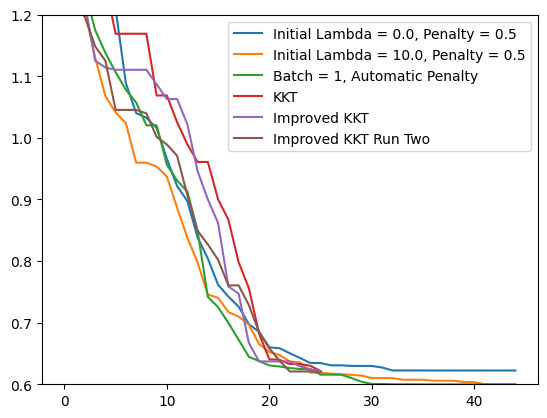

In [50]:
plt.plot(all_results_mean, label="Initial Lambda = 0.0, Penalty = 0.5")
plt.plot(updated_all_results_mean, label="Initial Lambda = 10.0, Penalty = 0.5")
# plt.plot(batch_all_results_mean, label="Batch = 3, Penalty Half")
# plt.plot(penalty_batch_all_results_mean, label="Batch = 3, Updated Proportional Penalty")
# plt.plot(larger_penalty_batch_all_results_mean, label="Batch = 3, Larger Initial Penalty")
# plt.plot(batch_one_all_results_mean, label="Batch = 1, Larger Initial Penalty")
plt.plot(batch_one_automatic_penalty_all_results_mean, label="Batch = 1, Automatic Penalty")
# plt.plot(batch_three_automatic_penalty_all_results_mean, label="Batch = 3, Automatic Penalty")
# plt.plot(fixed_lambda_results_mean, label="Fixed Lambda")
# plt.plot(exponent_results_mean, label="Exponential Movement")
plt.plot(kkt_results_mean, label="KKT")
plt.plot(improved_kkt_results_mean, label="Improved KKT")
plt.plot(improved_kkt_results_two_mean, label="Improved KKT Run Two")
plt.plot()
plt.ylim(0.6, 1.2)
plt.legend()
plt.show()

In [28]:
kkt_results_mean

array([1.44434697, 1.38446044, 1.37998639, 1.25827626, 1.2491423 ,
       1.1690087 , 1.1690087 , 1.1690087 , 1.1690087 , 1.06887042,
       1.06887042, 1.02530034, 0.98955327, 0.96085162, 0.96085162,
       0.90008306, 0.86731038, 0.7983529 , 0.75610306, 0.68197811,
       0.64051824, 0.63974371, 0.63279111, 0.63279111, 0.63002691,
       0.62140619])

In [13]:
batch_one_all_results

array([[1.76651844, 0.90552961, 0.90552961, 0.90552961, 0.90552961,
        0.90552961, 0.90552961, 0.90552961, 0.90552961, 0.90552961,
        0.90552961, 0.80797543, 0.80797543, 0.80797543, 0.62127363,
        0.62127363, 0.62127363, 0.62127363, 0.62127363, 0.62127363,
        0.60066944, 0.60066944, 0.60066944, 0.60018666, 0.60018666,
        0.6000849 , 0.59992676, 0.59992676, 0.59992676, 0.59992676,
        0.59992676, 0.59992676, 0.59980402, 0.59980402, 0.59980402,
        0.59980402, 0.59980402, 0.59980402, 0.59980402, 0.59980402,
        0.59980402, 0.59980402, 0.59980402, 0.59980402, 0.59980402],
       [1.76915179, 1.76915179, 1.76915179, 1.76915179, 1.76915179,
        1.76915179, 1.76915179, 1.76915179, 1.76915179, 0.62414451,
        0.62414451, 0.62414451, 0.62414451, 0.62414451, 0.62414451,
        0.62414451, 0.62414451, 0.60902628, 0.6001573 , 0.6001573 ,
        0.6001573 , 0.6001573 , 0.60003675, 0.60003675, 0.60003675,
        0.60003675, 0.60003675, 0.60003675, 0.6

### Plot Query Points on Objective

In [22]:
with open("results/31-01-23/run_16_data.pkl", "rb") as fp:
    data = pickle.load(fp)

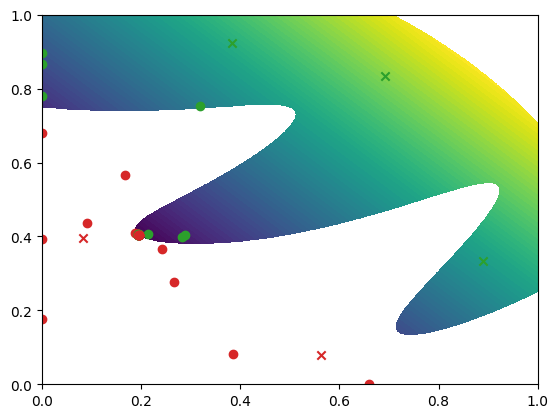

In [23]:
def masked_objective(x):
    mask_nan = np.logical_or(
        constraints.toy_constraint_one(x) > 0.0,
        constraints.toy_constraint_two(x) > 0.0,
    )
    y = np.array(objectives.linear_objective(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)


mask_fail1 = (
    data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().flatten() > 0
)
mask_fail2 = (
    data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().flatten() > 0
)
mask_fail = np.logical_or(mask_fail1, mask_fail2)

import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_function_2d, plot_bo_points

fig, ax = plot_function_2d(
    masked_objective,
    search_space.lower,
    search_space.upper,
    grid_density=1000,
    contour=True,
    fill=True,
)
plot_bo_points(
    data[OBJECTIVE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=NUM_INITIAL_SAMPLES,
    mask_fail=mask_fail,
)
plt.show()

### Progression of Lambda Over Time

#### Initial Penalty = 8

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


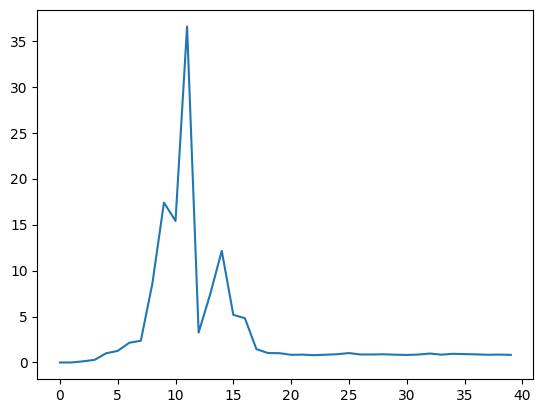

In [44]:
RUN = "two"

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])

In [45]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.0> Lambda: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0> Ineq Cons One: [-0.40950581], Objective: [1.23764966]
Iteration: 1 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.0> Lambda: [[0.]] Ineq Cons One: [0.99671592], Objective: [0.28255401]
Iteration: 2 Penalty: 4.0 Lambda: [[0.12458949]] Ineq Cons One: [0.64489591], Objective: [0.46531928]
Iteration: 3 Penalty: 2.0 Lambda: [[0.28581347]] Ineq Cons One: [1.43171872], Objective: [0.14736714]
Iteration: 4 Penalty: 1.0 Lambda: [[1.00167283]] Ineq Cons One: [0.25957579], Objective: [0.43232853]
Iteration: 5 Penalty: 0.5 Lambda: [[1.26124862]] Ineq Cons One: [0.44189998], Objective: [0.38777642]
Iteration: 6 Penalty: 0.25 Lambda: [[2.14504858]] Ineq Cons One: [0.05610963], Objective: [0.74321986]
Iteration: 7 Penalty: 0.125 Lambda: [[2.3694871]] Ineq Cons One: [0.77781969], Objective: [0.70270954]
Iteration: 8 Penalty: 0.0625 

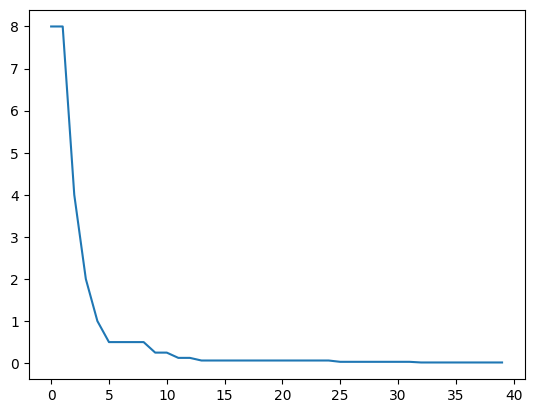

In [88]:
plt.plot(penalty_progression)

In [29]:
with open("results/08-02-23/run_three/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

In [30]:
data[INEQUALITY_CONSTRAINT_ONE].observations[5:]

#### Initial Penalty = 0.5

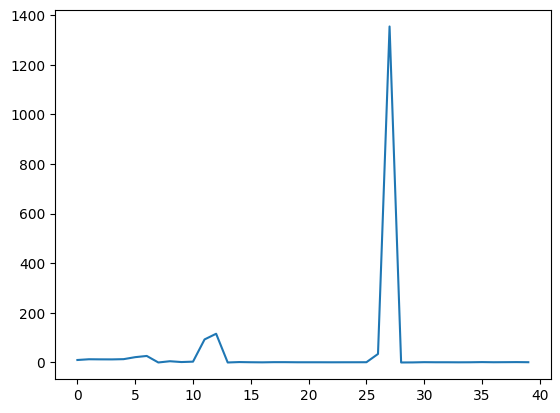

In [26]:
RUN = 8

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_data.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])

In [25]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5> Lambda: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=10.0> Ineq Cons One: [-0.34817185], Objective: [1.10642318]
Iteration: 1 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5> Lambda: [[9.30365629]] Ineq Cons One: [-0.05623176], Objective: [0.96427655]
Iteration: 2 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5> Lambda: [[9.19119277]] Ineq Cons One: [0.14229854], Objective: [1.11534039]
Iteration: 3 Penalty: 0.25 Lambda: [[9.47578986]] Ineq Cons One: [-1.09636306], Objective: [1.18214202]
Iteration: 4 Penalty: 0.25 Lambda: [[5.09033762]] Ineq Cons One: [0.32387659], Objective: [0.62990822]
Iteration: 5 Penalty: 0.125 Lambda: [[6.38584399]] Ineq Cons One: [1.72209553], Objective: [0.08482559]
Iteration: 6 Penalty: 0.0625 Lambda: [[20.16260825]] Ineq Cons One: [-1.10875269], Objective: [1.20919265]
Iteration: 7 Penalty: 0.0625 Lambda: [[2.42256526]] Ineq

#### Automatic Penalty

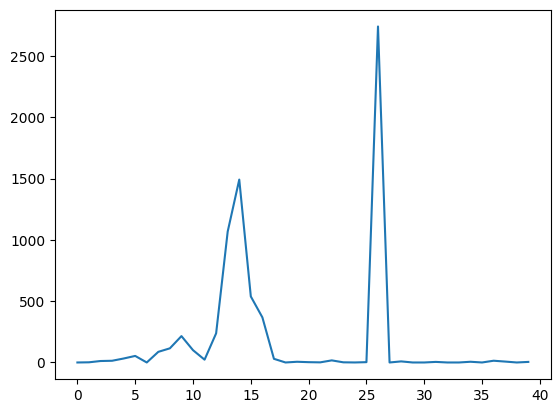

In [31]:
RUN = 8

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_data.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(tf.squeeze(inequality_lambda[INEQUALITY_CONSTRAINT_ONE]))

In [32]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.29544451]]])> Lambda: <tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.]]])> Ineq Cons One: [0.41947394], Objective: [0.72236867]
Iteration: 1 Penalty: [[[0.14772226]]] Lambda: [[[1.41980617]]] Ineq Cons One: [1.54962596], Objective: [0.01164716]
Iteration: 2 Penalty: [[[0.07386113]]] Lambda: [[[11.90993811]]] Ineq Cons One: [0.15085015], Objective: [0.77635976]
Iteration: 3 Penalty: [[[0.03693056]]] Lambda: [[[13.95228647]]] Ineq Cons One: [0.68009438], Objective: [0.69480114]
Iteration: 4 Penalty: [[[0.01846528]]] Lambda: [[[32.36777496]]] Ineq Cons One: [0.38927902], Objective: [0.93175301]
Iteration: 5 Penalty: [[[0.00923264]]] Lambda: [[[53.44944696]]] Ineq Cons One: [-0.77339934], Objective: [1.52224764]
Iteration: 6 Penalty: [[[0.00923264]]] Lambda: [[[0.]]] Ineq Cons One: [0.80094123], Objective: [0.27431741]
Iteration: 7 Penalty: [[[0.00461632]]] Lambda: [[[

### Batch Runs

In [23]:
run = 19

with open(f"results/09-02-23/batch_3_proportional_penalty/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
b = tf.transpose(tf.reshape(a, (14,3)))

NameError: name 'penalty_progression' is not defined

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


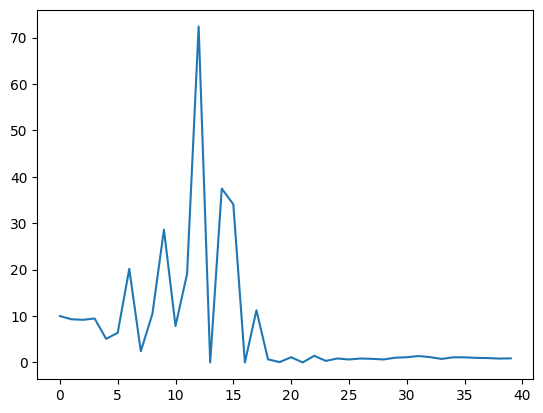

In [27]:
plt.plot(b[0])
plt.plot(b[1])
plt.plot(b[2])

### Second Experiment - Different Starting Lambda

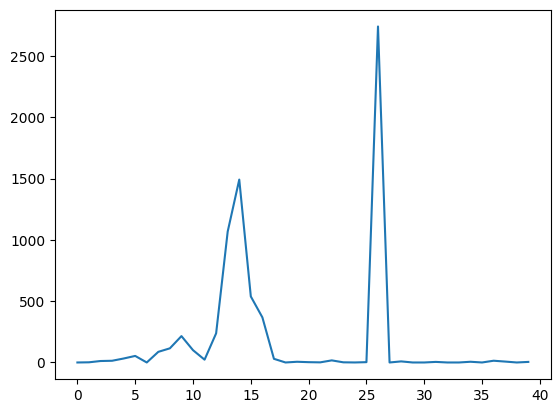

In [31]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(10.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(10.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    save_path = f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}"
    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space, save_lambda=True, save_path=save_path)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

### Experiment with Automatic Selection of Penalty

In [32]:
BATCH_SIZE = 3
NUM_BO_ITERS = 14

for run in range(18, 20):
    search_space = Box([0.0, 0.0], [1.0, 1.0])
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)
    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)

    constraint_one_satisfied = (tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_ONE].observations) <= 0)
    constraint_two_satisfied = (tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_TWO].observations) <= 0)
    all_satisfied = tf.logical_and(constraint_one_satisfied, constraint_two_satisfied)
    at_least_one_violated = tf.logical_not(all_satisfied)

    initial_penalty = None
    if tf.reduce_sum(tf.cast(at_least_one_violated, tf.int32)) == 0:
        # If valid everywhere, set initial penalty to one
        initial_penalty = 1
    else:
        invalid_ineq_one_squared = tf.square(tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_ONE].observations)[at_least_one_violated])
        invalid_ineq_two_squared = tf.square(tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_TWO].observations)[at_least_one_violated])
        sum_squared = invalid_ineq_one_squared + invalid_ineq_two_squared
        min_sum_squared = tf.math.reduce_min(sum_squared)
        if tf.reduce_sum(tf.cast(all_satisfied, tf.int32)) == 0:
            denominator = tfp.stats.percentile(initial_data[OBJECTIVE].observations, 50.0, interpolation='midpoint')
            initial_penalty = min_sum_squared / denominator
        else:
            best_valid_objective = tf.math.reduce_min(initial_data[OBJECTIVE].observations[all_satisfied])
            denominator = 2 * best_valid_objective
            initial_penalty = min_sum_squared / denominator

    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable([[[1.0], [2.0], [3.0]]], dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable([[[0.0], [0.0], [0.0]]], dtype=tf.float64)}
    print(f"Initial Penalty: {initial_penalty}")
    initial_penalty = tf.Variable([[[initial_penalty], [initial_penalty], [initial_penalty]]], dtype=tf.float64)
    print(f"Initial Penalty: {initial_penalty}")

    save_path = f"results/09-02-23/batch_3_automatic_penalty/run_{run}"
    augmented_lagrangian = BatchThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda,                                                                 None, BATCH_SIZE, initial_penalty, 0.001, search_space, True, save_path, NUM_BO_ITERS)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer(), num_query_points=BATCH_SIZE)
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(NUM_BO_ITERS, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/09-02-23/batch_3_automatic_penalty/run_{run}_data.pkl", "wb") as fp:
        pickle.dump(data, fp)

### Batch Experiment

Penalty just halves when violated

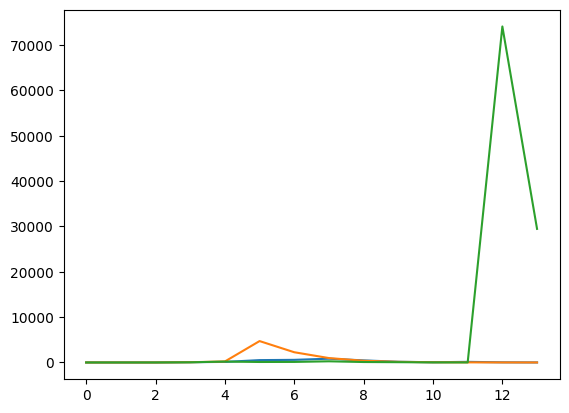

In [33]:
BATCH_SIZE = 1
NUM_BO_ITERS = 40

for run in range(20):
    search_space = Box([0.0, 0.0], [1.0, 1.0])
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)

    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable([[[0.0]]], dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable([[[0.0]]], dtype=tf.float64)}
    initial_penalty = tf.Variable([[[8.0]]], dtype=tf.float64)

    save_path = f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}"
    augmented_lagrangian = BatchThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda,                                                                 None, BATCH_SIZE, initial_penalty, 0.001, search_space, True, save_path, NUM_BO_ITERS)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer(), num_query_points=BATCH_SIZE)
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(NUM_BO_ITERS, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}_data.pkl", "wb") as fp:
        pickle.dump(data, fp)